# Distress Detection from Speech Data

Distress is defined as feeling of anxiety, fear and pain. Whenever a human being is in distress, it is reflected in their voice. Distress detection has many real life applications for elderly, people under protection, people living in dangerous areas, people travelling alone at night, etc. In this project, we are trying to detect distress from speech data using an artificial neural network.

In [0]:
# Importing necessary modules

import os
import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from keras.preprocessing.sequence import pad_sequences
from keras import Input
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, MaxPooling2D, LSTM, Dropout, GRU, Masking, TimeDistributed, Lambda, Permute, Concatenate
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import regularizers
import keras.backend as K
import tensorflow as tf
from aubio import pitch
from math import ceil
from keras.models import load_model

%matplotlib inline
sns.set()

Using TensorFlow backend.


## Dataset: CREMA-D
CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified).  
Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).
### Filename labeling conventions
The Actor id is a 4 digit number at the start of the file. Each subsequent identifier is separated by an underscore (_).  

Actors spoke from a selection of 12 sentences (in parentheses is the three letter acronym used in the second part of the filename):
* It's eleven o'clock (IEO).
* That is exactly what happened (TIE).
* I'm on my way to the meeting (IOM).
* I wonder what this is about (IWW).
* The airplane is almost full (TAI).
* Maybe tomorrow it will be cold (MTI).
* I would like a new alarm clock (IWL)
* I think I have a doctor's appointment (ITH).
* Don't forget a jacket (DFA).
* I think I've seen this before (ITS).
* The surface is slick (TSI).
* We'll stop in a couple of minutes (WSI).

The sentences were presented using different emotion (in parentheses is the three letter code used in the third part of the filename):

* Anger (ANG)
* Disgust (DIS)
* Fear (FEA)
* Happy/Joy (HAP)
* Neutral (NEU)
* Sad (SAD)

and emotion level (in parentheses is the two letter code used in the fourth part of the filename):

* Low (LO)
* Medium (MD)
* High (HI)
* Unspecified (XX)

In [0]:
# Loading the name of audio files
audio_files = os.listdir(r'AudioWAV')
audio_files = ['AudioWAV/'+file for file in audio_files]
label = [1] * len(audio_files)
label_binary = []
true_label = []

In [0]:
# Assigning a class label to each audio file
for i in range(len(audio_files)):
    name = audio_files[i].split('_')
    if 'ANG' in name:
        label[i] = 0
        label_binary.append(0)
        true_label.append('ang')
    elif 'FEA' in name:
        label[i] = 0
        label_binary.append(1)
        true_label.append('fea')
    elif 'DIS' in name:
        true_label.append('dis')
    elif 'SAD' in name:
        true_label.append('sad')
    elif 'HAP' in name:
        true_label.append('hap')
    elif 'NEU' in name:
        true_label.append('neu')

In [0]:
label = np.asarray(label)
label_binary = np.asarray(label_binary)
true_label = np.asarray(true_label)

We have decided to sample the audio files at  8000 Hz as most of the signals carrying human speech are in this range. Furthermore, we tested our models with files sampled at both 8000 Hz and 44.1 Khz and the result was similar. It's hard to work with files sampled at 44.1 Khz as that requires more computing resources which is also one of the reason we have decided to use a loww sampling rate.

In [0]:
# Global Constants
SR = 8000
LEN = 3
MAXLEN = SR*LEN
N_FFT = 2048
HOP_LENGTH = 512
N_MFCC = 20
TIMESTEPS = ceil(MAXLEN/HOP_LENGTH)

In [0]:
# Loading the wav files
data = [librosa.load(file, sr = SR)[0] for file in audio_files]

## Listening to Audio Files
### Distress
#### ANGER
<audio src="AudioWAV/1001_DFA_ANG_XX.wav" controls>Audio file not availablle</audio>
#### FEAR
<audio src="AudioWAV/1001_DFA_FEA_XX.wav" controls>Audio file not availablle</audio>
### OTHER
#### DISGUST
<audio src="AudioWAV/1001_DFA_DIS_XX.wav" controls>Audio file not availablle</audio>
##### HAPPY
<audio src="AudioWAV/1001_DFA_HAP_XX.wav" controls>Audio file not availablle</audio>
##### NEUTRAL
<audio src="AudioWAV/1001_DFA_NEU_XX.wav" controls>Audio file not availablle</audio>
##### SAD
<audio src="AudioWAV/1001_DFA_SAD_XX.wav" controls>Audio file not availablle</audio>

## Data Distribution

### ALL

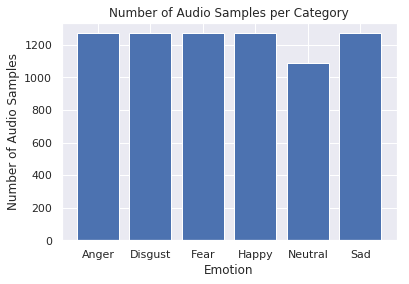

In [0]:
values, count = np.unique(true_label, return_counts=True)
plt.figsize = (16,10)
plt.bar(values, count)
plt.xlabel('Emotion')
plt.title('Number of Audio Samples per Category')
plt.ylabel('Number of Audio Samples')
plt.xticks(['ang', 'fea', 'dis', 'sad', 'hap', 'neu'], ['Anger', 'Fear', 'Disgust', 'Sad', 'Happy', 'Neutral'])
plt.show()

### Distress Vs. Other

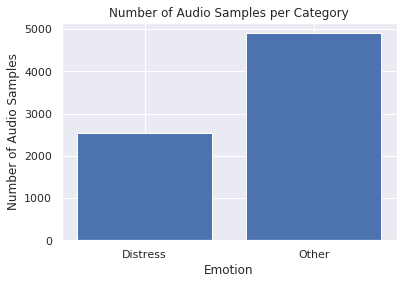

In [0]:
values, count = np.unique(label, return_counts=True)
plt.figsize = (16,10)
plt.bar(values, count)
plt.xlabel('Emotion')
plt.title('Number of Audio Samples per Category')
plt.ylabel('Number of Audio Samples')
plt.xticks([0, 1], ['Distress', 'Other'])
plt.show()

### Anger vs Fear

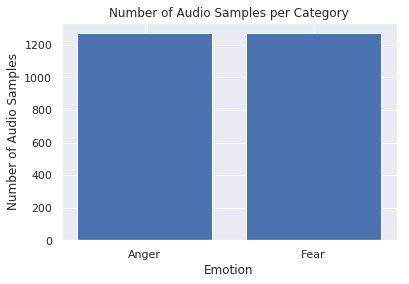

In [0]:
values, count = np.unique(label_binary, return_counts=True)
plt.figsize = (16,10)
plt.bar(values, count)
plt.xlabel('Emotion')
plt.title('Number of Audio Samples per Category')
plt.ylabel('Number of Audio Samples')
plt.xticks([0, 1], ['Anger', 'Fear'])
plt.show()

## Audio Length

In [0]:
# Finding the minimum and maximum duration of files in dataset
duration = [round(len(aud)/SR, 0) for aud in data]
print('Min Duration:' +str(min(duration))+' sec')
print('Max Duration:' +str(max(duration))+' sec')

Min Duration:1.0 sec
Max Duration:5.0 sec


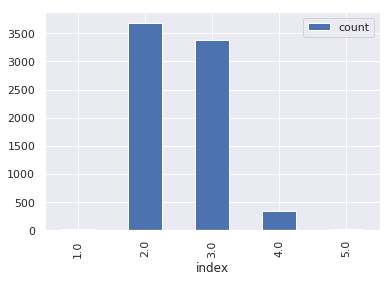

In [0]:
# Histogram of audio lengths
audio_length = pd.Series(duration).value_counts().reset_index()
audio_length.columns = ['index', 'count']
audio_length.sort_values(by = 'index', inplace=True)
audio_length.plot(kind = 'bar', x = 'index', y = 'count')

As we can see from the graph of length of audio files, most of the files are 2 or 3 seconds long. Hence, we have decided to convert all audio clips to 3 second long. We do this by padding shorter clips or by clipping files with longer duration. 

## Creating Datasets

In [0]:
# Padding
data = pad_sequences(data, maxlen=MAXLEN, padding='post', dtype = 'float32')

In [0]:
# Creating two datasets: One for distress vs other emotions and one for fear vs anger speech signals
data_dis = data[label==0]
data_oth = data[label!=0]
label_oth = true_label[~np.isin(true_label, ['ang', 'fea'])]

# Undersampling the over-represented class to get balanced dataset
data_oth, _ = train_test_split(data_oth, train_size = len(data_dis), stratify = label_oth)
data = np.concatenate([data_dis, data_oth], axis = 0)
label = np.array([0]*len(data_dis) + [1]*len(data_oth))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
# Pickling for faster access and memory efficiency
np.save('data', data)
np.save('label', label)
np.save('data_binary', data_dis)
np.save('label_binary', label_binary)

del data
del label
del data_oth
del label_oth
del data_dis

## Feature Retrievel

In [0]:
def get_pitch(file, n_fft, hop_length, samplerate):
    """
    Takes an array of raw audio data and returns pitch information
    """
    if len(file)%hop_length != 0:
      file = np.pad(file, (0, hop_length - (len(file)%hop_length)), mode='constant', constant_values=0)
    
    file = file.reshape(-1, hop_length)
    
    win_s = n_fft
    hop_s = hop_length

    tolerance = 0.8

    pitch_o = pitch("yin", win_s, hop_s, samplerate)
    pitch_o.set_unit("midi")
    pitch_o.set_tolerance(tolerance)

    pitches = np.apply_along_axis(lambda x: pitch_o(x)[0], axis=1, arr=file)
    
    return pitches[...,None]

In [0]:
def get_data(binary = False, feature = None, test = False):
    """
    Takes audio files and splits them into training and testing sets.
    By default, it return training data but if test is True it returns test data.
    If the binary parameter is set to true then only audio files belonging to FEAR and ANGER classes are considered.
    The feature parameter specifies the type of features extracted from audio files
    """
    if not binary:
        # Loading the audio files
        data = np.load('data.npy')
        # Loading labels
        label = np.load('label.npy')
    else:
        # Loading the audio files
        data = np.load('data_binary.npy')
        # Loading labels
        label = np.load('label_binary.npy')
    
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, label, stratify = label, random_state = 1024)
    
    del data
    del label
    
    # Returning test or train data
    if not test:
        del X_test
        del y_test
        data = X_train
        label = y_train
    else:
        del X_train
        del y_train
        data = X_test
        label = y_test
    
    if feature == 'RAW':
        data = np.expand_dims(data, axis = -1)

    if feature == 'STFT':
        data = np.transpose(np.abs(np.apply_along_axis(librosa.stft, 1, data, \
                                                       n_fft=N_FFT, hop_length=HOP_LENGTH)), (0,2,1))
    
    if feature == 'MFCC':
        data = np.transpose(np.apply_along_axis(librosa.feature.mfcc, 1, data, \
                                                       n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SR, n_mfcc=N_MFCC), (0,2,1))
    
    if feature == 'MFCCWDD':
        mfcc = np.apply_along_axis(librosa.feature.mfcc, 1, data, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SR, n_mfcc=N_MFCC)
        delta = np.stack([librosa.feature.delta(m) for m in mfcc])
        delta_delta = np.stack([librosa.feature.delta(m, order=2) for m in mfcc])
        data = np.transpose(np.concatenate([mfcc, delta, delta_delta], axis = 1), (0,2,1))
        
    if feature == 'CONT':
        stft = np.abs(np.apply_along_axis(librosa.stft, 1, data, n_fft=N_FFT, hop_length=HOP_LENGTH))
        rmse = np.stack([librosa.feature.rmse(S=s).T for s in stft])
        del stft
        zcr = np.transpose(np.apply_along_axis(librosa.feature.zero_crossing_rate, 1, data, \
                                               frame_length=N_FFT, hop_length=HOP_LENGTH), (0,2,1))
        pitch = np.apply_along_axis(get_pitch, 1, data, \
                                               n_fft=N_FFT, hop_length=HOP_LENGTH, samplerate=SR)
        
        data = np.concatenate([rmse, zcr, pitch], axis = -1)
        
    if feature == 'ALL':
        stft = get_data(binary=binary, feature = 'STFT', test=test)[0]
        mfccwdd = get_data(binary=binary, feature = 'MFCCWDD', test=test)[0]
        cont = get_data(binary=binary, feature = 'CONT', test=test)[0]
        data = np.concatenate([stft, mfccwdd, cont], axis = -1)
        
    return (data, label)

## Random Baseline

### Distress Vs Non-Distress

In [0]:
# Initializing the baseline classifier for three class classification
baseline = DummyClassifier()

# Getting the training and test data
X_train, y_train = get_data(binary=False, feature=None, test=False) 
X_test, y_test = get_data(binary=False, feature=None, test=True)

# Training the baseline model
baseline.fit(X_train, y_train)

# Getting the accuracy score for baseline
score = baseline.score(X_test, y_test)

print('Baseline for distress classification:', round(score*100, 4))

Baseline for distress classification: 51.2982


In [0]:
# Clean-up
del X_train, X_test, y_test, y_train

### Anger Vs. Fear

In [0]:
# Initializing the baseline classifier for three class classification
baseline = DummyClassifier()

# Getting the training and test data
X_train, y_train = get_data(binary=True, feature=None, test=False) 
X_test, y_test = get_data(binary=True, feature=None, test=True)

# Training the baseline model
baseline.fit(X_train, y_train)

# Getting the accuracy score for baseline
score = baseline.score(X_test, y_test)

print('Baseline for anger vs. fear classification:', round(score*100, 4))

Baseline for anger vs. fear classification: 49.5283


In [0]:
# Clean-up
del X_train, X_test, y_test, y_train

## Audio Features

* Pitch (no)
* Fundamental Frequency (no)
* MFCC (yes)
* MFCC with Delta and Delta-Delta Coefficients (yes)
* STFT (no)
* TEO (yes if there's time)
* Mel Spectogram (no)

For each feature:
* RNN
* CNN

Final model:
* Ensemble of best models

### Distress Vs. Other

In [0]:
# Stores model accuracy as weight for weighted ensemble
weights = []

#### Raw Audio

In [0]:
# Getting raw audio files as 3D array with added depth dimension
X_train, y_train = get_data(binary = False, feature = 'RAW')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train)


In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 3431
Number of validation examples: 382


In [0]:
# Model architecture

input_tensor = Input(shape = (MAXLEN, 1))
x = Conv1D(16, 11, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(input_tensor)
x = Conv1D(16, 11, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = MaxPooling1D(16)(x)
x = Dropout(0.1)(x)
x = Conv1D(32, 11, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = Conv1D(32, 11, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = MaxPooling1D(8)(x)
x = Dropout(0.1)(x)
x = Conv1D(64, 9, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = Conv1D(64, 9, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = MaxPooling1D(4)(x)
x = Dropout(0.1)(x)
x = Conv1D(128, 7, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = Conv1D(128, 7, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = MaxPooling1D(4)(x)
x = Dropout(0.1)(x)
x = Conv1D(256, 5, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = Conv1D(256, 5, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = MaxPooling1D(2)(x)
x = Conv1D(512, 3, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = Conv1D(512, 3, activation='relu', kernel_initializer='he_normal', padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
output = Dense(1, activation='sigmoid')(x)
model_raw = Model(input_tensor, output)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Model summary
model_raw.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24000, 16)         192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24000, 16)         2832      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1500, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1500, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1500, 32)          5664      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1500, 32)          11296     
__________

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model
callback_list = [EarlyStopping(monitor='val_acc', patience=50, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_acc', save_best_only=True)]

In [0]:
# Compiling Model
model_raw.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_raw.fit(X_train, y_train, epochs = 1000, batch_size = 128, callbacks=callback_list, validation_data = (X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 3431 samples, validate on 382 samples
Epoch 1/1000
3431/3431 [==============================] - 12s 4ms/step - loss: 4.6050 - acc: 0.5433 - val_loss: 4.5174 - val_acc: 0.7277
Epoch 2/1000
3431/3431 [==============================] - 3s 915us/step - loss: 4.4235 - acc: 0.6269 - val_loss: 4.3350 - val_acc: 0.7016
Epoch 3/1000
3431/3431 [==============================] - 3s 922us/step - loss: 4.2424 - acc: 0.6911 - val_loss: 4.1485 - val_acc: 0.6937
Epoch 4/1000
3431/3431 [==============================] - 3s 923us/step - loss: 4.0773 - acc: 0.6940 - val_loss: 4.0074 - val_acc: 0.6702
Epoch 5/1000
3431/3431 [==============================] - 3s 928us/step - loss: 3.9213 - acc: 0.6972 - val_loss: 3.8537 - val_acc: 0.6832
Epoch 6/1000
3431/3431 [==============================] - 3s 922us/step - loss: 3.7786 - acc: 0.6992 - val_loss: 3.7233 - val_acc: 0.6780
Epoch 7/1000
3431/3431 [==============================] - 3s 931us/step - loss

In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=False, feature='RAW', test=True)
score = model_raw.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

1271/1271 [==============================] - 1s 932us/step
Test Accuracy:  68.6861


In [0]:
# Saving the model
model_raw.save('distress_model_raw.h5')

In [0]:
# Garbage Disposal
del model_raw, X_train, y_train, X_valid, y_valid, X_test, y_test

#### Spectogram and Discrete Fourier Transform

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.[[wikipedia](https://en.wikipedia.org/wiki/Spectrogram)]  

In mathematics, the discrete Fourier transform (DFT) converts a finite sequence of equally-spaced samples of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier transform (DTFT), which is a complex-valued function of frequency. The DFT is said to be a frequency domain representation of the original input sequence.[[wikipedia](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)]  

One of the most popular ways to perform DFT on audio signals is usng STFT which stands for Short-Time Fourier Transform. The short-time Fourier transform (STFT), is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. In practice, the procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment. This reveals the Fourier spectrum on each shorter segment.[[wikipedia](https://en.wikipedia.org/wiki/Short-time_Fourier_transform#Continuous-time_STFT)]  

In [0]:
# Getting STFT transformation of audio files
X_train, y_train = get_data(binary = False, feature = 'STFT')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train)

In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 3431
Number of validation examples: 382


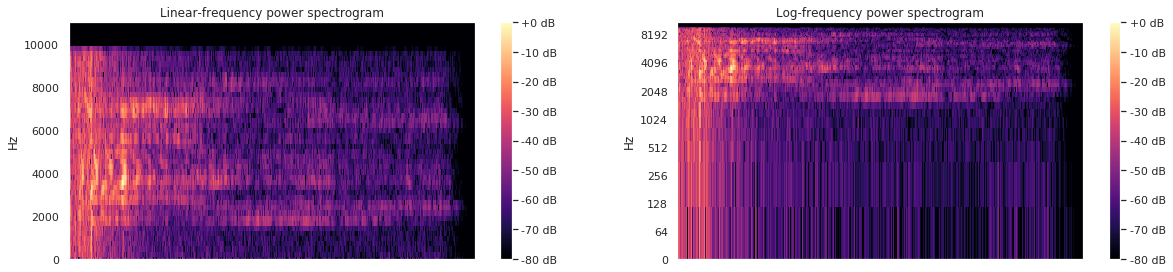

In [0]:
mat = librosa.amplitude_to_db(np.abs(X_train[0]), ref = np.max)

plt.figure(figsize = (20,20))
# Spectogram in linear scale
plt.subplot(4, 2, 1)
specshow(mat, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Spectogram on Log-Scale
plt.subplot(4, 2, 2)
specshow(mat, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

# Displaying the graphs
plt.show()

# Clean-up
del mat

In [0]:
# Layers used in the model
conv1 = Conv1D(256, 9, padding='same', activation='relu', kernel_initializer='he_normal')
conv2 = Conv1D(128, 9, padding='same', activation='relu', kernel_initializer='he_normal')
pool1 = MaxPooling1D(4)
drop1 = Dropout(0.5)
conv3 = Conv1D(128, 7, padding='same', activation='relu', kernel_initializer='he_normal')
conv4 = Conv1D(64, 7, padding='same', activation='relu', kernel_initializer='he_normal')
pool2 = MaxPooling1D(2)
drop2 = Dropout(0.5)
conv5 = Conv1D(64, 5, padding='same', activation='relu', kernel_initializer='he_normal')
conv6 = Conv1D(32, 5, padding='same', activation='relu', kernel_initializer='he_normal')
pool3 = MaxPooling1D(2)
drop3 = Dropout(0.5)
flat1 = Flatten()
logistic_regression = Dense(1, activation='sigmoid')

In [0]:
# Model Architecture
stft_input = Input(shape=(X_train.shape[1:]))
x = conv1(stft_input)
x = conv2(x)
x = pool1(x)
x = drop1(x)
x = conv3(x)
x = conv4(x)
x = pool2(x)
x = drop2(x)
x = conv5(x)
x = conv6(x)
x = pool3(x)
x = drop3(x)
x = flat1(x)
stft_output = logistic_regression(x)
model_stft = Model(stft_input, stft_output)

In [0]:
# Model summary
model_stft.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 47, 1025)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 47, 256)           2361856   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 47, 128)           295040    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 11, 128)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 11, 128)           114816    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 11, 64)            57408     
__________

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model
callback_list = [EarlyStopping(monitor='val_acc', patience=50, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_acc', save_best_only=True)]

In [0]:
# Compiling Model
model_stft.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_stft.fit(X_train, y_train, epochs = 1000, batch_size = 128, callbacks=callback_list, validation_data = (X_valid, y_valid))

Train on 3431 samples, validate on 382 samples
Epoch 1/1000
3431/3431 [==============================] - 3s 957us/step - loss: 1.3858 - acc: 0.5133 - val_loss: 0.6124 - val_acc: 0.5183
Epoch 2/1000
3431/3431 [==============================] - 1s 329us/step - loss: 0.8761 - acc: 0.5325 - val_loss: 0.6133 - val_acc: 0.5759
Epoch 3/1000
3431/3431 [==============================] - 1s 325us/step - loss: 0.7508 - acc: 0.5616 - val_loss: 0.6166 - val_acc: 0.6859
Epoch 4/1000
3431/3431 [==============================] - 1s 322us/step - loss: 0.7130 - acc: 0.5718 - val_loss: 0.6081 - val_acc: 0.6859
Epoch 5/1000
3431/3431 [==============================] - 1s 326us/step - loss: 0.6737 - acc: 0.5742 - val_loss: 0.6103 - val_acc: 0.7225
Epoch 6/1000
3431/3431 [==============================] - 1s 327us/step - loss: 0.6587 - acc: 0.6080 - val_loss: 0.6016 - val_acc: 0.7304
Epoch 7/1000
3431/3431 [==============================] - 1s 325us/step - loss: 0.6539 - acc: 0.6092 - val_loss: 0.5986 - val

In [0]:
# Saving the validation accuracy as model weight for weighted ensemble
score = model_stft.evaluate(X_valid, y_valid)
weights.append(round(score[1], 4))

382/382 [==============================] - 0s 576us/step


In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=False, feature='STFT', test=True)
score = model_stft.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

1271/1271 [==============================] - 1s 425us/step
Test Accuracy:  73.3281


In [0]:
# Saving the model
model_stft.save('distress_STFT.h5')

In [0]:
# Garbage disposal
del model_stft, X_train, y_train, X_valid, y_valid, X_test, y_test

#### Mel-Frequency Cepstral Coefficients with Delta and Delta-Delta Coefficients

In [0]:
# Note: We have tried the following models:
# 1) CNN layers with logistic regression layer at the end working on flattened output of CNN base
# 2) RNN layers with logistic regression layer at the end
# 3) CNN layers with logistic regression layer applied at each time step and the final prediction is mean of individual prediction for each timestep
# 3) RNN layers with logistic regression layer applied at each time step and the final prediction is mean of individual prediction for each timestep
# 4) A wide number of combinations of RNN and CNN layers

In [0]:
# Obtaining MFCC, DELTA and DELTA-DELTA Features
X_train, y_train = get_data(binary = False, feature = 'MFCCWDD')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train)

In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 3431
Number of validation examples: 382


In [0]:
# Model Architecture

# CNN model 1 - uses a kernel of window length 1
conv_inp1 = Input(shape = (60, 47))
x = Conv1D(32, 1, padding='same', activation = 'relu', kernel_initializer='he_normal')(conv_inp1)
x = Conv1D(16, 1, padding='same', activation='relu', kernel_initializer='he_normal')(x)
conv_out1 = Conv1D(8, 1, padding='same', activation='relu', kernel_initializer='he_normal')(x)
model_conv1 = Model(conv_inp1, conv_out1)

# CNN model 2 - uses a kernel of window length 5
conv_inp2 = Input(shape = (60, 47))
x = Conv1D(32, 5, padding='same', activation = 'relu', kernel_initializer='he_normal')(conv_inp2)
x = Conv1D(16, 5, padding='same', activation='relu', kernel_initializer='he_normal')(x)
conv_out2 = Conv1D(8, 5, padding='same', activation='relu', kernel_initializer='he_normal')(x)
model_conv2 = Model(conv_inp2, conv_out2)

# Main model - combination of GRU and CNN layers
# The GRU layers work in time dimension and learn about the changes in all feature coefficients with time
# The CNN models work in feature dimension and learn about the changes in feature coefficients in a specific window over time
mfccwdd_inp = Input(shape = (47, 60))
x = GRU(60, return_sequences=True, dropout=0.2, recurrent_dropout=0.3)(mfccwdd_inp)
x = GRU(60, return_sequences=True, dropout=0.2, recurrent_dropout=0.3)(x)
x = Permute((2,1))(x)
x1 = model_conv1(x)
x2 = model_conv2(x)
x = Concatenate(axis = 1)([x1, x2])
x = Flatten()(x)
mfccwdd_out = Dense(1, activation='sigmoid')(x)
model_mfccwdd = Model(mfccwdd_inp, mfccwdd_out)

In [0]:
# Model Summary
model_mfccwdd.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 47, 60)       0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 47, 60)       21780       input_5[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 47, 60)       21780       gru_1[0][0]                      
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 60, 47)       0           gru_2[0][0]                      
__________________________________________________________________________________________________
model_3 (M

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model
callback_list = [EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_loss', save_best_only=True)]

In [0]:
# Compiling Model
model_mfccwdd.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_mfccwdd.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_data = (X_valid, y_valid), callbacks = callback_list)

Train on 3431 samples, validate on 382 samples
Epoch 1/1000
3431/3431 [==============================] - 7s 2ms/step - loss: 0.7019 - acc: 0.5200 - val_loss: 0.6740 - val_acc: 0.6126
Epoch 2/1000
3431/3431 [==============================] - 4s 1ms/step - loss: 0.6793 - acc: 0.5783 - val_loss: 0.6541 - val_acc: 0.6440
Epoch 3/1000
3431/3431 [==============================] - 4s 1ms/step - loss: 0.6638 - acc: 0.6126 - val_loss: 0.6401 - val_acc: 0.6675
Epoch 4/1000
3431/3431 [==============================] - 4s 1ms/step - loss: 0.6619 - acc: 0.6033 - val_loss: 0.6303 - val_acc: 0.6702
Epoch 5/1000
3431/3431 [==============================] - 4s 1ms/step - loss: 0.6492 - acc: 0.6313 - val_loss: 0.6236 - val_acc: 0.6728
Epoch 6/1000
3431/3431 [==============================] - 5s 1ms/step - loss: 0.6412 - acc: 0.6473 - val_loss: 0.6151 - val_acc: 0.6885
Epoch 7/1000
3431/3431 [==============================] - 4s 1ms/step - loss: 0.6394 - acc: 0.6301 - val_loss: 0.6137 - val_acc: 0.6859
E

In [0]:
# Saving the validation accuracy as model weight for weighted ensemble
score = model_mfccwdd.evaluate(X_valid, y_valid)
weights.append(round(score[1], 4))

382/382 [==============================] - 1s 2ms/step


In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=False, feature='MFCCWDD', test=True)
score = model_mfccwdd.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

1271/1271 [==============================] - 3s 2ms/step
Test Accuracy:  70.417


In [0]:
# Saving model
model_mfccwdd.save('distress_MFCCWDD.h5')

In [0]:
# Garbage disposal
del model_mfccwdd , X_train, y_train, X_valid, y_valid, X_test, y_test

#### Continuous Features

In [0]:
# Obtaining above mentioned continuous features
X_train, y_train = get_data(binary = False, feature = 'CONT')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train)

In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 3431
Number of validation examples: 382


In [0]:
# Layers used in the model
conv1 = Conv1D(16, 9, padding='same', activation = 'relu')
conv2 = Conv1D(16, 9, padding='same', activation='relu')
pool1 = MaxPooling1D(2)
drop1 = Dropout(0.2)
conv3 = Conv1D(32, 7, padding='same', activation='relu')
conv4 = Conv1D(32, 7, padding='same', activation='relu')
pool2 = MaxPooling1D(2)
drop2 = Dropout(0.2)
conv5 = Conv1D(64, 5, padding='same', activation='relu')
conv6 = Conv1D(64, 5, padding='same', activation='relu')
pool3 = MaxPooling1D(2)
drop3 = Dropout(0.2)
flat1 = Flatten()
logistic_regression = Dense(1, activation='sigmoid')

In [0]:
# Model Architecture
cont_inp = Input(shape=(47, 3))
x = conv1(cont_inp)
x = conv2(x)
x = pool1(x)
x = drop1(x)
x = conv3(x)
x = conv4(x)
x = pool2(x)
x = drop2(x)
x = conv5(x)
x = conv6(x)
x = pool3(x)
x = drop3(x)
x = flat1(x)
cont_out = logistic_regression(x)
model_cont = Model(cont_inp, cont_out)

In [0]:
# Model Summary
model_cont.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 47, 3)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 47, 16)            448       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 47, 16)            2320      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 23, 16)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 23, 16)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 23, 32)            3616      
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 23, 32)            7200      
__________

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model
callback_list = [EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_acc', save_best_only=True)]

In [0]:
# Compiling Model
model_cont.compile(optimizer = Adam(lr = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_cont.fit(X_train, y_train, epochs = 1000, batch_size = 128, callbacks=callback_list, validation_split = 0.1)

Train on 3087 samples, validate on 344 samples
Epoch 1/1000
3087/3087 [==============================] - 2s 579us/step - loss: 0.7888 - acc: 0.4976 - val_loss: 0.6938 - val_acc: 0.5058
Epoch 2/1000
3087/3087 [==============================] - 0s 68us/step - loss: 0.6935 - acc: 0.5050 - val_loss: 0.6909 - val_acc: 0.5407
Epoch 3/1000
3087/3087 [==============================] - 0s 67us/step - loss: 0.6943 - acc: 0.5160 - val_loss: 0.6877 - val_acc: 0.5581
Epoch 4/1000
3087/3087 [==============================] - 0s 66us/step - loss: 0.6851 - acc: 0.5565 - val_loss: 0.6798 - val_acc: 0.5669
Epoch 5/1000
3087/3087 [==============================] - 0s 69us/step - loss: 0.6723 - acc: 0.5799 - val_loss: 0.6539 - val_acc: 0.5843
Epoch 6/1000
3087/3087 [==============================] - 0s 68us/step - loss: 0.6443 - acc: 0.6236 - val_loss: 0.6186 - val_acc: 0.6570
Epoch 7/1000
3087/3087 [==============================] - 0s 73us/step - loss: 0.6067 - acc: 0.6660 - val_loss: 0.6129 - val_acc: 

In [0]:
# Saving the validation accuracy as model weight for weighted ensemble
score = model_cont.evaluate(X_valid, y_valid)
weights.append(round(score[1], 4))

382/382 [==============================] - 0s 127us/step


In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=False, feature='CONT', test=True)
score = model_cont.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

1271/1271 [==============================] - 0s 74us/step
Test Accuracy:  68.5287


In [0]:
# Saving Model
model_cont.save('distress_CONT.h5')

In [0]:
# Garbage disposal
del model_cont, X_train, y_train, X_valid, y_valid, X_test, y_test

#### Combined

In [0]:
# Obtaining above mentioned continuous features
X_train, y_train = get_data(binary = False, feature = 'ALL')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train)

In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 3431
Number of validation examples: 382


In [0]:
# Layers used in the model
conv1 = Conv1D(512, 9, padding='same', activation = 'relu')
conv2 = Conv1D(512, 9, padding='same', activation='relu')
pool1 = MaxPooling1D(2)
drop1 = Dropout(0.5)
conv3 = Conv1D(256, 7, padding='same', activation='relu')
conv4 = Conv1D(256, 7, padding='same', activation='relu')
pool2 = MaxPooling1D(2)
drop2 = Dropout(0.5)
conv5 = Conv1D(128, 5, padding='same', activation='relu')
conv6 = Conv1D(128, 5, padding='same', activation='relu')
pool3 = MaxPooling1D(2)
drop3 = Dropout(0.5)
flat1 = Flatten()
logistic_regression = Dense(1, activation='sigmoid')

In [0]:
# Model Architecture
comb_inp = Input(shape=(47, 1088))
x = conv1(comb_inp)
x = conv2(x)
x = pool1(x)
x = drop1(x)
x = conv3(x)
x = conv4(x)
x = pool2(x)
x = drop2(x)
x = conv5(x)
x = conv6(x)
x = pool3(x)
x = drop3(x)
x = flat1(x)
comb_out = logistic_regression(x)
model_combined = Model(comb_inp, comb_out)

In [0]:
# Model Summary
model_combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 47, 1088)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 47, 512)           5014016   
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 47, 512)           2359808   
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 23, 512)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 23, 512)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 23, 256)           917760    
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 23, 256)           459008    
__________

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model
callback_list = [EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_acc', save_best_only=True)]

In [0]:
# Compiling Model
model_combined.compile(optimizer = Adam(lr = 0.00001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_combined.fit(X_train, y_train, epochs = 500, batch_size = 128, validation_split = 0.1)

Train on 3087 samples, validate on 344 samples
Epoch 1/500
3087/3087 [==============================] - 6s 2ms/step - loss: 3.5154 - acc: 0.5053 - val_loss: 0.6484 - val_acc: 0.5959
Epoch 2/500
3087/3087 [==============================] - 3s 818us/step - loss: 2.4918 - acc: 0.5274 - val_loss: 0.6281 - val_acc: 0.6541
Epoch 3/500
3087/3087 [==============================] - 3s 815us/step - loss: 1.8286 - acc: 0.5322 - val_loss: 0.6125 - val_acc: 0.6831
Epoch 4/500
3087/3087 [==============================] - 3s 820us/step - loss: 1.4866 - acc: 0.5578 - val_loss: 0.6000 - val_acc: 0.6773
Epoch 5/500
3087/3087 [==============================] - 2s 800us/step - loss: 1.2472 - acc: 0.5734 - val_loss: 0.5973 - val_acc: 0.6860
Epoch 6/500
3087/3087 [==============================] - 2s 799us/step - loss: 1.1123 - acc: 0.5763 - val_loss: 0.5922 - val_acc: 0.6919
Epoch 7/500
3087/3087 [==============================] - 2s 799us/step - loss: 1.0554 - acc: 0.5633 - val_loss: 0.6056 - val_acc: 0.6

In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=False, feature='ALL', test=True)
score = model_combined.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

1271/1271 [==============================] - 1s 691us/step
Test Accuracy:  73.0134


In [0]:
# Saving the model
model_combined.save('disress_model_combined.h5')

In [0]:
# Garbage Disposal
del model_combined, X_train, y_train, X_valid, y_valid, X_test, y_test

#### Ensemble

Ensembling is a powerful technique which is used to create a strong model from multiple weak models. We have decided to use a weighted average ensemble such that the contribution of each weak model is weighted by how accurate it is on held-out test data.

In [0]:
def ensemble(features, weights):
  """
  Obtains predictions from each model, scales their prediction by the weights stored in weights array, and sums up the weighted predictions
  to give the final prediction.
  """
  
  # Obtaining prediction from each model
  estimated_label = []
  for feat in features:
    X_test, y_test = get_data(binary = True, feature = feat, test = True)
    model = load_model('distress_'+feat+'.h5')
    yhat = model.predict(X_test)
    yhat = np.concatenate([yhat, 1-yhat], axis = -1)
    estimated_label.append(yhat)
  
  # Normalizing weights
  normalized_weights = weights/np.sum(weights)
  # Scaling predictions of models by their corresponding weight
  weighted_label = [el*nw for el, nw in zip(estimated_label, normalized_weights)]
  
  # Weighted prediction
  yhat = np.sum(weighted_label, axis = 0)
  predicted_label = np.argmin(yhat, axis=1)
  
  # Ensemble Accuracy
  ensemble_accuracy = round(np.sum(np.equal(predicted_label, y_test), axis = None)*100/len(y_test), 2)
  print('Ensemble Accuracy:', ensemble_accuracy)

In [0]:
# Calling the ensemble for individual models
features = ['MFCCWDD', 'CONT', 'STFT']
ensemble(features, weights)

Ensemble Accuracy: 71.38


### Anger Vs. Fear

In [0]:
# Stores the model accuracy as weight for weighed ensemble
weights = []

#### Raw Audio

In [0]:
# Getting raw audio files resampled to 8000 Hz
X_train, y_train = get_data(binary = True, feature = 'RAW')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train)

In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 1715
Number of validation examples: 191


In [0]:
# Model Architecture
input_tensor = Input(shape = (MAXLEN, 1))
x = Conv1D(16, 21, activation='relu', kernel_initializer='he_normal', padding = 'same')(input_tensor)
x = Conv1D(16, 21, activation='relu', kernel_initializer='he_normal', padding = 'same')(x)
x = MaxPooling1D(64)(x)
x = Dropout(0.2)(x)
x = Conv1D(32, 21, activation='relu', kernel_initializer='he_normal', padding = 'same')(x)
x = Conv1D(32, 21, activation='relu', kernel_initializer='he_normal', padding = 'same')(x)
x = MaxPooling1D(8)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 9, activation='relu', kernel_initializer='he_normal', padding = 'same')(x)
x = Conv1D(64, 9, activation='relu', kernel_initializer='he_normal', padding = 'same')(x)
x = MaxPooling1D(4)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 7, activation='relu', kernel_initializer='he_normal', padding = 'same')(x)
x = Conv1D(128, 7, activation='relu', kernel_initializer='he_normal', padding = 'same')(x)
x = MaxPooling1D(4)(x)
x = Dropout(0.2)(x)
x = Conv1D(256, 5, activation='relu', kernel_initializer='he_normal', padding = 'same')(x)
x = Conv1D(256, 5, activation='relu', kernel_initializer='he_normal', padding = 'same')(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
output = Dense(1, activation='sigmoid')(x)
model_raw = Model(input_tensor, output)

In [0]:
# Model Summary
model_raw.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 24000, 1)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 24000, 16)         352       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 24000, 16)         5392      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 375, 16)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 375, 16)           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 375, 32)           10784     
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 375, 32)           21536     
__________

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model or if the model starts to overfit. 
callback_list = [EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_acc', save_best_only=True)]

In [0]:
# Compiling Model
model_raw.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_raw.fit(X_train, y_train, epochs = 1000, batch_size = 128, callbacks=callback_list, validation_data = (X_valid, y_valid))

Train on 1715 samples, validate on 191 samples
Epoch 1/1000
1715/1715 [==============================] - 6s 4ms/step - loss: 0.7161 - acc: 0.5102 - val_loss: 0.6360 - val_acc: 0.5026
Epoch 2/1000
1715/1715 [==============================] - 2s 1ms/step - loss: 0.6422 - acc: 0.5324 - val_loss: 0.6511 - val_acc: 0.7016
Epoch 3/1000
1715/1715 [==============================] - 2s 975us/step - loss: 0.6294 - acc: 0.5767 - val_loss: 0.6330 - val_acc: 0.6911
Epoch 4/1000
1715/1715 [==============================] - 2s 973us/step - loss: 0.6217 - acc: 0.6175 - val_loss: 0.6273 - val_acc: 0.7487
Epoch 5/1000
1715/1715 [==============================] - 2s 980us/step - loss: 0.6124 - acc: 0.7195 - val_loss: 0.6233 - val_acc: 0.7644
Epoch 6/1000
1715/1715 [==============================] - 2s 980us/step - loss: 0.5973 - acc: 0.7522 - val_loss: 0.6062 - val_acc: 0.7539
Epoch 7/1000
1715/1715 [==============================] - 2s 982us/step - loss: 0.5775 - acc: 0.7819 - val_loss: 0.5859 - val_acc

In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=True, feature='RAW', test=True)
score = model_raw.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

636/636 [==============================] - 0s 702us/step
Test Accuracy:  88.522


In [0]:
# Saving the model
model_raw.save('binary_model_raw.h5')

In [0]:
# Garbage disposal
del model_raw, X_train, y_train, X_valid, y_valid, X_test, y_test

#### Spectogram and Discrete Fourier Transform

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.[[wikipedia](https://en.wikipedia.org/wiki/Spectrogram)]  

In mathematics, the discrete Fourier transform (DFT) converts a finite sequence of equally-spaced samples of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier transform (DTFT), which is a complex-valued function of frequency. The DFT is said to be a frequency domain representation of the original input sequence.[[wikipedia](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)]  

One of the most popular ways to perform DFT on audio signals is usng STFT which stands for Short-Time Fourier Transform. The short-time Fourier transform (STFT), is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. In practice, the procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment. This reveals the Fourier spectrum on each shorter segment.[[wikipedia](https://en.wikipedia.org/wiki/Short-time_Fourier_transform#Continuous-time_STFT)]  

In [0]:
# Getting STFT transformation of audio files
X_train, y_train = get_data(binary = True, feature = 'STFT')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train) 

In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 1715
Number of validation examples: 191


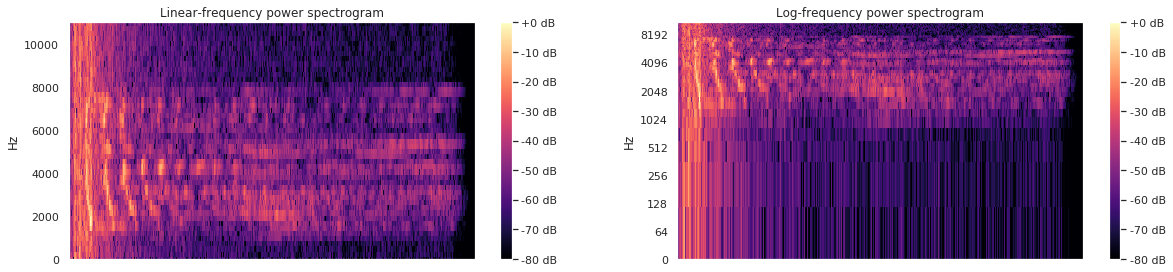

In [0]:
mat = librosa.amplitude_to_db(np.abs(X_train[0]), ref = np.max)

plt.figure(figsize = (20,20))
# Spectogram in linear scale
plt.subplot(4, 2, 1)
specshow(mat, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Spectogram on Log-Scale
plt.subplot(4, 2, 2)
specshow(mat, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

# Displaying the graphs
plt.show()

# Clean-up
del mat

In [0]:
# Layers used in the model
conv1 = Conv1D(128, 9, padding='same', activation='relu', kernel_initializer='he_normal')
conv2 = Conv1D(64, 9, padding='same', activation='relu', kernel_initializer='he_normal')
pool1 = MaxPooling1D(2)
drop1 = Dropout(0.8)
conv3 = Conv1D(64, 7, padding='same', activation='relu', kernel_initializer='he_normal')
conv4 = Conv1D(32, 7, padding='same', activation='relu', kernel_initializer='he_normal')
pool2 = MaxPooling1D(2)
drop2 = Dropout(0.8)
flat1 = Flatten()
logistic_regression = Dense(1, activation='sigmoid')

In [0]:
# Model Architecture
stft_input = Input(shape=(TIMESTEPS, 1025))
x = conv1(stft_input)
x = conv2(x)
x = pool1(x)
x = drop1(x)
x = conv3(x)
x = conv4(x)
x = pool2(x)
x = drop2(x)
x = flat1(x)
stft_output = logistic_regression(x)
model_stft = Model(stft_input, stft_output)

In [0]:
# Model Summary
model_stft.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 47, 1025)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 47, 128)           1180928   
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 47, 64)            73792     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 23, 64)            0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 23, 64)            0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 23, 64)            28736     
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 23, 32)            14368     
__________

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model or if the model starts to overfit. 
callback_list = [EarlyStopping(monitor='val_loss', patience=50, min_delta=1e-5, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_loss', save_best_only=True)]

In [0]:
# Compiling Model
model_stft.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_stft.fit(X_train, y_train, epochs = 1000, batch_size = 128, callbacks=callback_list, validation_data = (X_valid, y_valid))

Train on 1715 samples, validate on 191 samples
Epoch 1/1000
1715/1715 [==============================] - 4s 2ms/step - loss: 3.4371 - acc: 0.5055 - val_loss: 0.6638 - val_acc: 0.6597
Epoch 2/1000
1715/1715 [==============================] - 0s 288us/step - loss: 2.4163 - acc: 0.5236 - val_loss: 0.6315 - val_acc: 0.6597
Epoch 3/1000
1715/1715 [==============================] - 0s 277us/step - loss: 2.0571 - acc: 0.5055 - val_loss: 0.6104 - val_acc: 0.6963
Epoch 4/1000
1715/1715 [==============================] - 0s 263us/step - loss: 1.6555 - acc: 0.5096 - val_loss: 0.5962 - val_acc: 0.6911
Epoch 5/1000
1715/1715 [==============================] - 0s 270us/step - loss: 1.2853 - acc: 0.5487 - val_loss: 0.5896 - val_acc: 0.7435
Epoch 6/1000
1715/1715 [==============================] - 0s 266us/step - loss: 0.9860 - acc: 0.5522 - val_loss: 0.6132 - val_acc: 0.7592
Epoch 7/1000
1715/1715 [==============================] - 0s 271us/step - loss: 0.9311 - acc: 0.5557 - val_loss: 0.6212 - val_a

In [0]:
# Saving the validation accuracy as model weight for weighted ensemble
score = model_stft.evaluate(X_valid, y_valid)
weights.append(round(score[1], 4))

191/191 [==============================] - 0s 633us/step


In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=True, feature='STFT', test=True)
score = model_stft.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

636/636 [==============================] - 0s 328us/step
Test Accuracy:  83.6478


In [0]:
# Saving the model
model_stft.save('binary_STFT.h5')

In [0]:
# Garbage disposal
del model_stft, X_train, y_train, X_valid, y_valid, X_test, y_test

#### Mel-Frequency Cepstral Coefficients with Delta and Delta-Delta Coefficients

In [0]:
# Note: The model accuracy increases upto 95% if the sampling rate of original audio files is high. 
# We tried inverting the time and feature dimensions and got almost similar performance but a more complex model was required in the second 
# scenario so we dedided to go with this one (occam's razor!).

In [0]:
# Obtaining MFCC, DELTA and DELTA-DELTA Features
X_train, y_train = get_data(binary = True, feature = 'MFCCWDD')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train)

In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 1715
Number of validation examples: 191


In [0]:
# Layers used in the model
conv1 = Conv1D(64, 7, padding='same', activation = 'relu')
conv2 = Conv1D(64, 7, padding='same', activation='relu')
pool1 = MaxPooling1D(4)
drop1 = Dropout(0.8)
conv3 = Conv1D(128, 5, padding='same', activation='relu')
conv4 = Conv1D(128, 5, padding='same', activation='relu')
pool2 = MaxPooling1D(2)
drop2 = Dropout(0.8)
flat1 = Flatten()
logistic_regression = Dense(1, activation='sigmoid')

In [0]:
# Model architecture
mfccwdd_inp = Input(shape=(TIMESTEPS, N_MFCC*3))
x = conv1(mfccwdd_inp)
x = conv2(x)
x = pool1(x)
x = drop1(x)
x = conv3(x)
x = conv4(x)
x = pool2(x)
x = drop2(x)
x = flat1(x)
mfccwdd_out = logistic_regression(x)
model_mfccwdd = Model(mfccwdd_inp, mfccwdd_out)

In [0]:
# Model Summary
model_mfccwdd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 47, 60)            0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 47, 64)            26944     
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 47, 64)            28736     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 11, 64)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 11, 128)           41088     
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 11, 128)           82048     
__________

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model or if the model starts to overfit. 
callback_list = [EarlyStopping(monitor='val_loss', patience=50, min_delta=1e-5, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_loss', save_best_only=True)]

In [0]:
# Compiling Model
model_mfccwdd.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_mfccwdd.fit(X_train, y_train, epochs = 1000, batch_size = 128, callbacks=callback_list, validation_data = (X_valid, y_valid))

Train on 1715 samples, validate on 191 samples
Epoch 1/1000
1715/1715 [==============================] - 3s 2ms/step - loss: 7.5339 - acc: 0.4980 - val_loss: 4.3918 - val_acc: 0.5183
Epoch 2/1000
1715/1715 [==============================] - 0s 88us/step - loss: 7.1977 - acc: 0.5207 - val_loss: 4.1565 - val_acc: 0.5288
Epoch 3/1000
1715/1715 [==============================] - 0s 85us/step - loss: 7.1852 - acc: 0.5178 - val_loss: 4.2352 - val_acc: 0.5288
Epoch 4/1000
1715/1715 [==============================] - 0s 84us/step - loss: 7.2156 - acc: 0.5207 - val_loss: 2.5294 - val_acc: 0.5864
Epoch 5/1000
1715/1715 [==============================] - 0s 89us/step - loss: 7.4956 - acc: 0.4991 - val_loss: 1.5744 - val_acc: 0.6911
Epoch 6/1000
1715/1715 [==============================] - 0s 85us/step - loss: 6.9768 - acc: 0.5341 - val_loss: 1.6200 - val_acc: 0.6963
Epoch 7/1000
1715/1715 [==============================] - 0s 84us/step - loss: 7.2443 - acc: 0.5143 - val_loss: 1.4339 - val_acc: 0.

In [0]:
# Saving the validation accuracy as model weight for weighted ensemble
score = model_mfccwdd.evaluate(X_valid, y_valid)
weights.append(round(score[1], 4))

191/191 [==============================] - 0s 312us/step


In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=True, feature='MFCCWDD', test=True)
score = model_mfccwdd.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

636/636 [==============================] - 0s 150us/step
Test Accuracy:  87.5786


In [0]:
# Saving Model
model_mfccwdd.save('binary_MFCCWDD.h5')

In [0]:
# Garbage disposal
del model_mfccwdd, X_train, y_train, X_valid, y_valid, X_test, y_test

#### Continuous Features

In [0]:
# Obtaining above mentioned continuous features
X_train, y_train = get_data(binary = True, feature = 'CONT')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train)

In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 1715
Number of validation examples: 191


In [0]:
# Layers used in the model
conv1 = Conv1D(16, 9, padding='same', activation = 'relu')
conv2 = Conv1D(16, 9, padding='same', activation='relu')
pool1 = MaxPooling1D(2)
drop1 = Dropout(0.2)
conv3 = Conv1D(32, 7, padding='same', activation='relu')
conv4 = Conv1D(32, 7, padding='same', activation='relu')
pool2 = MaxPooling1D(2)
drop2 = Dropout(0.2)
conv5 = Conv1D(64, 5, padding='same', activation='relu')
conv6 = Conv1D(64, 5, padding='same', activation='relu')
pool3 = MaxPooling1D(2)
drop3 = Dropout(0.2)
flat1 = Flatten()
logistic_regression = Dense(1, activation='sigmoid')

In [0]:
# Model Architecture
cont_inp = Input(shape=(TIMESTEPS, 3))
x = conv1(cont_inp)
x = conv2(x)
x = pool1(x)
x = drop1(x)
x = conv3(x)
x = conv4(x)
x = pool2(x)
x = drop2(x)
x = conv5(x)
x = conv6(x)
x = pool3(x)
x = drop3(x)
x = flat1(x)
cont_out = logistic_regression(x)
model_cont = Model(cont_inp, cont_out)

In [0]:
# Model Summary
model_cont.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 47, 3)             0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 47, 16)            448       
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 47, 16)            2320      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 23, 16)            0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 23, 16)            0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 23, 32)            3616      
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 23, 32)            7200      
__________

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model
callback_list = [EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_loss', save_best_only=True)]

In [0]:
# Compiling Model
model_cont.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_cont.fit(X_train, y_train, epochs = 1000, batch_size = 128, callbacks=callback_list, validation_data = (X_valid, y_valid))

Train on 1715 samples, validate on 191 samples
Epoch 1/1000
1715/1715 [==============================] - 4s 2ms/step - loss: 1.2792 - acc: 0.4910 - val_loss: 0.8184 - val_acc: 0.4974
Epoch 2/1000
1715/1715 [==============================] - 0s 67us/step - loss: 0.9854 - acc: 0.4927 - val_loss: 0.6974 - val_acc: 0.5236
Epoch 3/1000
1715/1715 [==============================] - 0s 69us/step - loss: 0.8403 - acc: 0.5166 - val_loss: 0.6831 - val_acc: 0.5079
Epoch 4/1000
1715/1715 [==============================] - 0s 66us/step - loss: 0.7814 - acc: 0.5359 - val_loss: 0.6741 - val_acc: 0.5497
Epoch 5/1000
1715/1715 [==============================] - 0s 63us/step - loss: 0.7715 - acc: 0.5090 - val_loss: 0.6701 - val_acc: 0.5916
Epoch 6/1000
1715/1715 [==============================] - 0s 66us/step - loss: 0.7452 - acc: 0.5213 - val_loss: 0.6643 - val_acc: 0.5916
Epoch 7/1000
1715/1715 [==============================] - 0s 65us/step - loss: 0.7204 - acc: 0.5522 - val_loss: 0.6585 - val_acc: 0.

In [0]:
# Saving the validation accuracy as model weight for weighted ensemble
score = model_cont.evaluate(X_valid, y_valid)
weights.append(round(score[1], 4))

191/191 [==============================] - 0s 214us/step


In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=True, feature='CONT', test=True)
score = model_cont.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

636/636 [==============================] - 0s 99us/step
Test Accuracy:  82.3899


In [0]:
# Saving Model
model_cont.save('binary_CONT.h5')

In [0]:
# Garbage Disposal
del model_cont, X_train, y_train, X_valid, y_valid, X_test, y_test

#### Combined

In [0]:
# Obtaining above mentioned continuous features
X_train, y_train = get_data(binary = True, feature = 'ALL')
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train)

In [0]:
print('Number of training examples:', len(X_train))
print('Number of validation examples:', len(X_valid))

Number of training examples: 1715
Number of validation examples: 191


In [0]:
# Layers used in the model
conv1 = Conv1D(512, 9, padding='same', activation = 'relu')
conv2 = Conv1D(512, 9, padding='same', activation='relu')
pool1 = MaxPooling1D(2)
drop1 = Dropout(0.5)
conv3 = Conv1D(256, 7, padding='same', activation='relu')
conv4 = Conv1D(256, 7, padding='same', activation='relu')
pool2 = MaxPooling1D(2)
drop2 = Dropout(0.5)
conv5 = Conv1D(128, 5, padding='same', activation='relu')
conv6 = Conv1D(128, 5, padding='same', activation='relu')
pool3 = MaxPooling1D(2)
drop3 = Dropout(0.5)
flat1 = Flatten()
logistic_regression = Dense(1, activation='sigmoid')

In [0]:
# Model Architecture
combined_inp = Input(shape=(TIMESTEPS, 1088))
x = conv1(combined_inp)
x = conv2(x)
x = pool1(x)
x = drop1(x)
x = conv3(x)
x = conv4(x)
x = pool2(x)
x = drop2(x)
x = conv5(x)
x = conv6(x)
x = pool3(x)
x = drop3(x)
x = flat1(x)
combined_out = logistic_regression(x)
model_combined = Model(combined_inp, combined_out)

In [0]:
# Model Summary
model_combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 47, 1088)          0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 47, 512)           5014016   
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 47, 512)           2359808   
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 23, 512)           0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 23, 512)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 23, 256)           917760    
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 23, 256)           459008    
__________

In [0]:
# Using Early Stopping to stop training early if there's no improvement in model
callback_list = [EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
                ModelCheckpoint(filepath = 'compressed_model.h5', monitor = 'val_loss', save_best_only=True)]

In [0]:
# Compiling Model
model_combined.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
# Training Model
history = model_combined.fit(X_train, y_train, epochs = 1000, batch_size = 128, callbacks=callback_list, validation_data = (X_valid, y_valid))

Train on 1715 samples, validate on 191 samples
Epoch 1/1000
1715/1715 [==============================] - 6s 4ms/step - loss: 2.5195 - acc: 0.5609 - val_loss: 0.5861 - val_acc: 0.7330
Epoch 2/1000
1715/1715 [==============================] - 2s 880us/step - loss: 0.9304 - acc: 0.6822 - val_loss: 0.5146 - val_acc: 0.7382
Epoch 3/1000
1715/1715 [==============================] - 1s 823us/step - loss: 0.6363 - acc: 0.7359 - val_loss: 0.4922 - val_acc: 0.7382
Epoch 4/1000
1715/1715 [==============================] - 1s 821us/step - loss: 0.5988 - acc: 0.7464 - val_loss: 0.4834 - val_acc: 0.7487
Epoch 5/1000
1715/1715 [==============================] - 1s 820us/step - loss: 0.5350 - acc: 0.7644 - val_loss: 0.4824 - val_acc: 0.7539
Epoch 6/1000
1715/1715 [==============================] - 1s 841us/step - loss: 0.5105 - acc: 0.7563 - val_loss: 0.4844 - val_acc: 0.7382
Epoch 7/1000
1715/1715 [==============================] - 1s 825us/step - loss: 0.4879 - acc: 0.7726 - val_loss: 0.4604 - val_a

In [0]:
# Test Accuracy
X_test, y_test = get_data(binary=True, feature='ALL', test=True)
score = model_combined.evaluate(X_test, y_test)
print('Test Accuracy: ', round(score[1]*100, 4))

636/636 [==============================] - 1s 820us/step
Test Accuracy:  90.4088


In [0]:
# Saving the model
model_combined.save('binary_model_combined.h5')

In [0]:
# Garbage Disposal
del model_combined, X_train, y_train, X_valid, y_valid, X_test, y_test

#### Ensemble

Ensembling is a powerful technique which is used to create a strong model from multiple weak models. We have decided to use a weighted average ensemble such that the contribution of each weak model is weighted by how accurate it is on held-out test data.

In [0]:
def ensemble(features, weights):
  """
  Obtains predictions from each model, scales their prediction by the weights stored in weights array, and sums up the weighted predictions
  to give the final prediction.
  """
  
  # Obtaining prediction from each model
  estimated_label = []
  for feat in features:
    X_test, y_test = get_data(binary = True, feature = feat, test = True)
    model = load_model('binary_'+feat+'.h5')
    yhat = model.predict(X_test)
    yhat = np.concatenate([yhat, 1-yhat], axis = -1)
    estimated_label.append(yhat)
  
  # Normalizing weights
  normalized_weights = weights/np.sum(weights)
  # Scaling predictions of models by their corresponding weight
  weighted_label = [el*nw for el, nw in zip(estimated_label, normalized_weights)]
  
  # Weighted prediction
  yhat = np.sum(weighted_label, axis = 0)
  predicted_label = np.argmin(yhat, axis=1)
  
  # Ensemble Accuracy
  ensemble_accuracy = round(np.sum(np.equal(predicted_label, y_test), axis = None)*100/len(y_test), 2)
  print('Ensemble Accuracy:', ensemble_accuracy)

In [0]:
# Calling the ensemble for given features
features = ['MFCCWDD', 'CONT', 'STFT']
ensemble(features, weights)

Ensemble Accuracy: 88.21
